# Seattle Airbnb Analysis
**Summary**

I am currently writing this from an Airbnb next to Olympic National Park. I became curious about the
popularity of Airbnbs in Washington, especially because of Airbnb’s increasing popularity and the
resurgence of travel post-pandemic. This analysis targets trends in tourism in Seattle, and uses machine
learning to predict where the most profitable Airbnbs will populate in the future. The results can be used by
hosts to help boost their ratings and increase the number of bookings, and can help analyze Seattle’s
tourism economy as a whole. As an economics major, I am also currently exploring how Airbnb is affecting
our local economy; with the regulations being implemented on Airbnbs in New York, I believe it would be
interesting to identify whether it’s possible that Seattle would face similar legal challenges. I chose to focus
on Seattle specifically in the interest of computer storage and time. Once my code runs successfully, I hope
to expand it to multiple cities in order to be able to identify national trends.

1. Which neighborhoods in Seattle are the most popular for Airbnbs?
2. Which neighborhoods in Seattle contain the most expensive Airbnbs?
3. Given different factors, which Airbnbs are predicted to be popular?
4. Does having a profile picture affect the popularity of a host's listing?

# Challenge Goals
In addition to a csv and geodataframe, I am using a geojson for my map, which we did not use in class and
is considered messy data. Additionally, I hypothesize that having a host profile picture will increase the
number of bookings for their listing. I will be using altair in order to create interactive datasets. I hope to
create results that are user-friendly to be used by hosts in order to help them easily understand what factors
increase the popularity of Airbnb listings, and for city planners and policymakers to understand trends in
Airbnbs throughout Seattle. I have never used this libraries, but the interactive graph at the end of our
education assignment intrigued me, and I would like to learn how to do something similar.
Additionally, I will be using machine learning to predict the most popular Airbnbs on a longitude-latitude
map. I will be using scikit-learn to compare three different classification methods: LinearSVC, Decision Tree
Classification, and Random Forest.

# Data Setting and Methods
I first imported all of my libraries and functions. Then, I loaded in my listings as both a csv and a
GeoDataFrame, as well as a map of Seattle as a geojson. I also changed the formats of price to exclude
dollar signs so they could be used as a float. In methods, the dataset may be manipulated (such as adding
columns), but the specifications above are the only ones consistent throughout all of the code.
I have separated my graphs and answers to research questions into different methods. Additionally, there is
more analysis in project_code that I opted not to include here due to relevancy and organization. In
project_code.ipynb, the last code cell contains a short explanation of each method, as well as a
commented line that can be uncommented to run the method. This helps keep my code organized and run
efficiently, as opposed to running all code at once. The methods are a combination of number comparisons,
graphs, maps, and machine learning classification methods.

In [9]:
# !pip install scikit-learn
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib
# !pip install geopandas
# !pip install numpy
# !pip install altair
# !pip install -q folium mapclassify

In [10]:
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import altair as alt
import doctest
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
sns.set_theme()

In [3]:
# load in listings as a csv and gdf, change price to float, load in map as a geojson
listing_path = "listings.csv"
map_path = "neighbourhoods.geojson"
listings_test = pd.read_csv("listings-small.csv").set_index("id")
listings = pd.read_csv(listing_path).set_index("id")
listing_gdf = gpd.GeoDataFrame(
    listings,
    # crs="EPSG:4326" specifies WGS84 or GPS coordinate system, see https://epsg.io/4326
    geometry=gpd.points_from_xy(listings["longitude"], listings["latitude"], crs="EPSG:4326")
)
listings["price"] = listings["price"].replace("[\\$,]", "", regex=True).astype(float)
gjsn = gpd.read_file(map_path)

assert listing_path.endswith('.csv'), "listings must be a csv"
assert map_path.endswith('.geojson'), "listings must be a geojson"

# Results
## 1. Which neighborhoods in Seattle are the most popular for Airbnbs?
I found that Broadway and Belltown had the highest number of listings in Seattle, by far. These did not
surprise me, as waterfront properties and listings in the heart of Capitol Hill's bustling streets have lots of
activities for visitors. I also found that Holly Park and the Industrial District were the least popular; this could be that they have less restaurants and activities, are more expensive to purchase properties, or are more
dangerous. Interestingly, I also found that Holly Park had the highest Airbnb rating, which could be due to a
lack of Airbnbs there. Visualizations below.
## 2. Which neighborhoods in Seattle contain the most expensive Airbnbs?
My map found that expensive Airbnbs were fairly evenly distributed among different neighborhoods, with a
weak correlation of waterfront properties being more expensive. I also found that the majority of Airbnbs
are less than $750, with 99.9% of Airbnbs being less than $2100.
## 3. Given different factors, which Airbnbs are predicted to be popular?
I found that decision tree binary classification consistently had the highest accuracy of the three methods I
used, and is the easiest to understand when visualized. It found that Airbnbs that are cheaper than $145.5
and accomodate less than 9.5 people are most likely to be popular. While this means this is a correlation, it
is also possible that these Airbnbs are just booked more often due to affordability and accomodation needs.
## 4. Does having a profile picture affect the popularity of a host's listing?
Surprisingly, my analysis found that the mean number of bookings for hosts with profile pictures was
actually less than those with a profile picture. However, the median for hosts with profile pictures is greater
than those without. This leads me to conclude that there are outliers with profile pictures and no bookings
that are affecting the mean, and my hypothesis can be neither proved nor disproved.

In [4]:
# 1. Which neighborhoods in Seattle are the most popular for Airbnbs?
"""
explore an interactive map of all listings in Seattle
"""
listing_gdf.explore(column="neighbourhood_group_cleansed")

"""
plots a bar chart with each neighborhood in Seattle (x-axis) and the number of Airbnbs as the y-axis
Made interactive using altair due to large num of neighbourhoods.
"""
neighbourhood_counts = listings.groupby("neighbourhood_cleansed").size().reset_index(name="count")

num_chart = alt.Chart(neighbourhood_counts).mark_bar().encode(
    x=alt.X("neighbourhood_cleansed:N", title="Neighbourhood"),
    y=alt.Y("count:Q", title="Number of Listings"),
    tooltip=["neighbourhood_cleansed", "count"]
).properties(
    width=800,
    height=400,
    title="Number of Airbnb Listings by Neighbourhood"
).interactive()

num_chart.display()


"""
plots a bar chart with each neighborhood in Seattle (x-axis) and the average rating of Airbnbs as the y-axis.
Made interactive using altair
"""
listing_df_clean = listings.dropna(subset=["review_scores_rating"])
neighbourhood_stats = listing_df_clean.groupby("neighbourhood_cleansed")["review_scores_rating"].agg(["mean", "count"])
neighbourhood_stats = neighbourhood_stats[neighbourhood_stats["count"] > 0]
neighbourhood_stats["mean"] = neighbourhood_stats["mean"].round(2)
mean_rating = neighbourhood_stats["mean"].to_dict()

neighbourhood_stats_altair = neighbourhood_stats.reset_index()

rating_chart = alt.Chart(neighbourhood_stats_altair).mark_bar().encode(
    x="neighbourhood_cleansed:N",
    y="mean:Q",
    tooltip=["neighbourhood_cleansed", "mean"]
).properties(
    width=800,
    height=400,
    title="Mean Ratings by Neighbourhood"
).interactive()

rating_chart.display()

unique = listings.neighbourhood_cleansed.unique()
assert len(unique) == 88, "Number of neighbourhoods does not match"

alt.Chart(...)

alt.Chart(...)

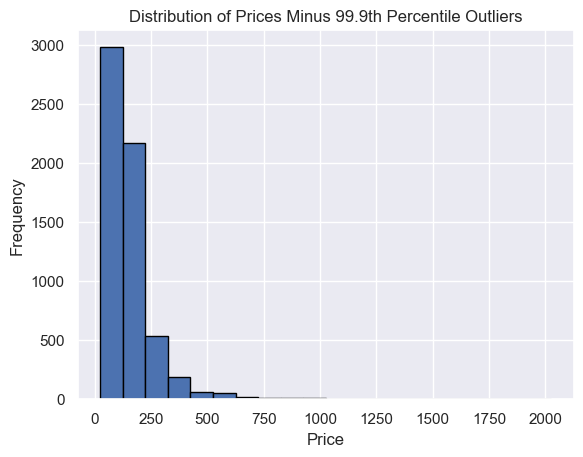

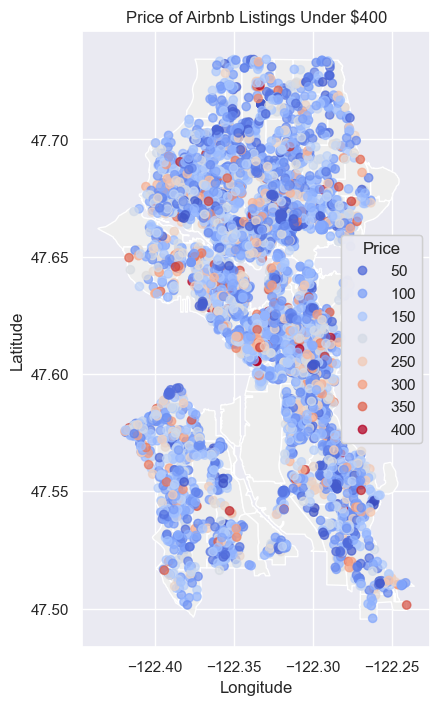

In [5]:
# 2. Which neighborhoods in Seattle contain the most expensive Airbnbs?
# What does the price distribution of Airbnbs look like?
"""
Maps a histogram of prices
"""
listings_filtered = listings[listings["price"] <= 2100]

plt.hist(listings_filtered["price"], bins=20, edgecolor="black")

# Add labels and title
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Distribution of Prices Minus 99.9th Percentile Outliers")
# ax.set_ylim(ymax=2000)

plt.show()


"""
Creates a scatterplot representing a map of Seattle and the average price
of Airbnbs (red = more expensive, blue = cheaper)
"""
# the price threshold can be changed. I found that including listings above this made it difficult to
# distinguish different prices on the map, because the majority of them are <= $400.
price_threshold = 400

listings_filtered = listings[listings["price"] <= price_threshold]

latitude = listings_filtered["latitude"]
longitude = listings_filtered["longitude"]
price = listings_filtered["price"]

fig, ax = plt.subplots(figsize=(10, 8))
gjsn.plot(ax=ax, color="#EEE")

sc = ax.scatter(longitude, latitude, c=price, cmap="coolwarm", alpha=0.7)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Price of Airbnb Listings Under $" + str(price_threshold))

# USED AI IN LINE 23: prompt: what is *sc matplotlib
legend1 = ax.legend(*sc.legend_elements(), title="Price")
ax.add_artist(legend1)

plt.show()

assert ax.get_xlabel() == "Longitude", "x-label must be longitude"
assert ax.get_ylabel() == "Latitude", "y-label must be latitude"
for i in listings_filtered["price"]:
    assert i <= int(price_threshold), "all prices included must be <= threshold"
    assert i > 0, "all prices must be greater than 0"

Accuracy of Model: 0.7388535031847133
price 0.6779987590521438
accommodates 0.08493521762923933
review_scores_rating 0.1974232704526128
host_response_rate 0.03964275286600395
Mean Squared Error: 0.2611464968152866


0.2611464968152866

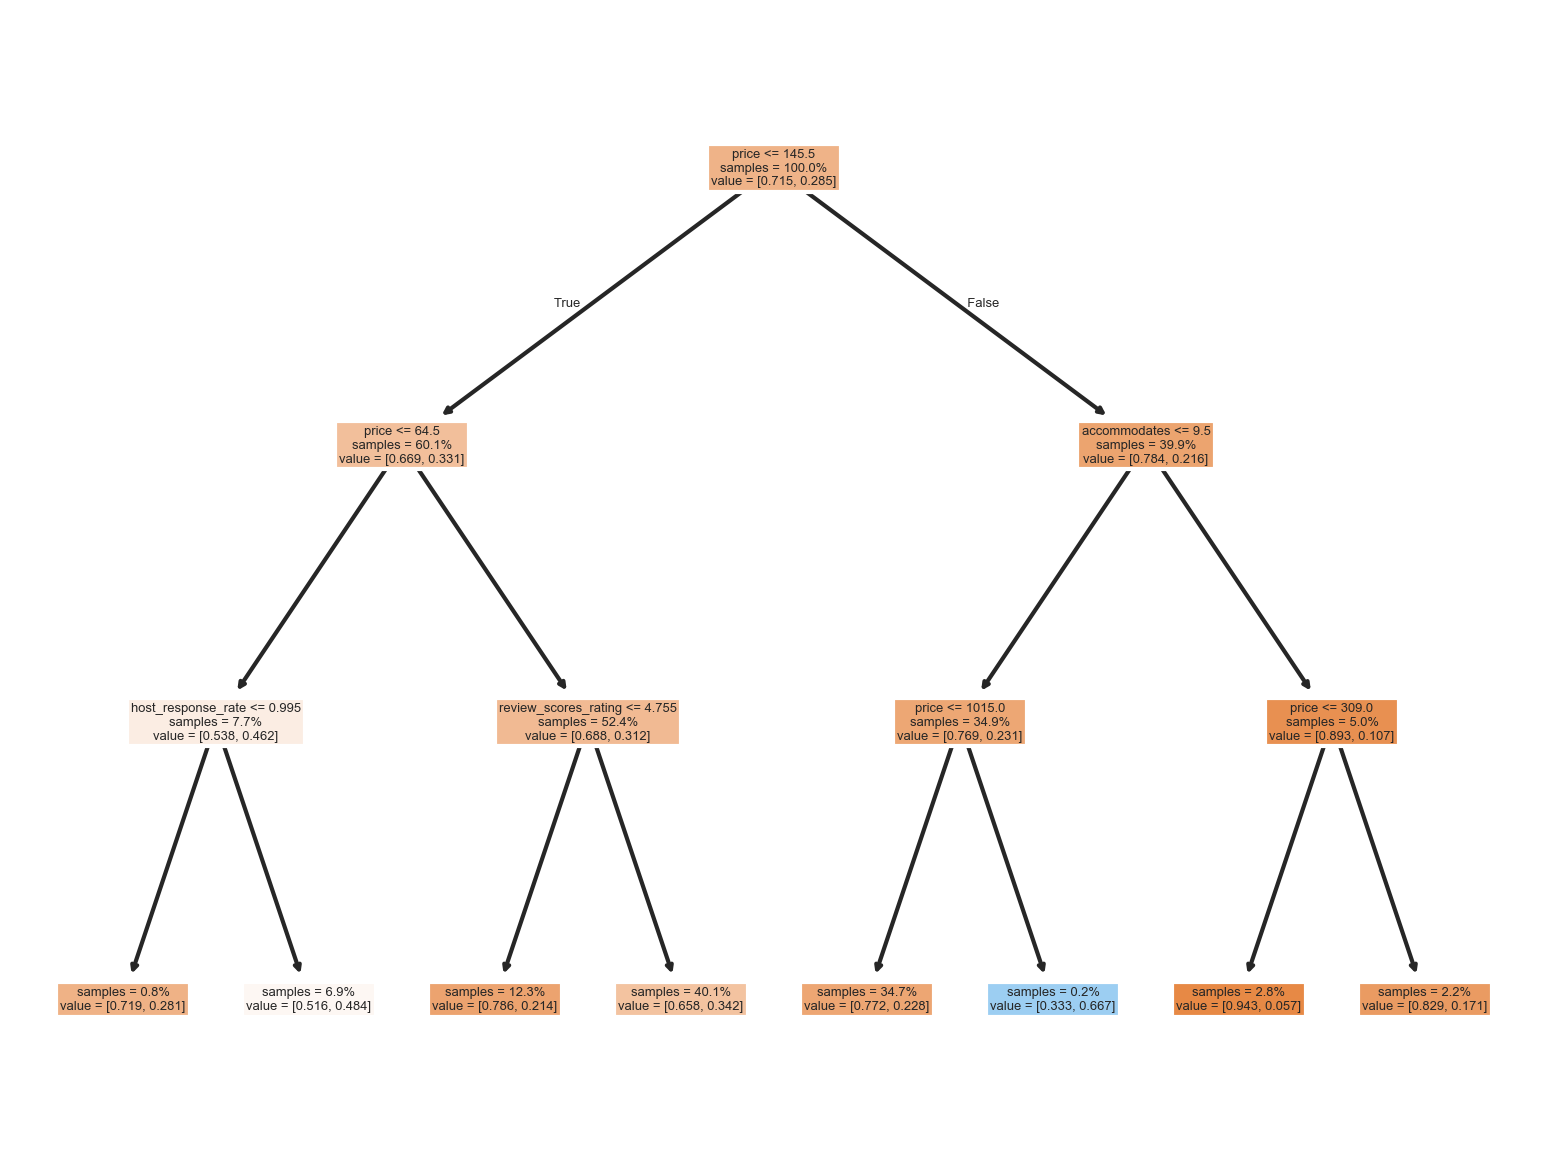

In [6]:
# 3. Given different factors, which Airbnbs are predicted to be popular?
def linear_svc(listings) -> float:
    """
    Use LinearSVC to determine whether availability_365 will be <= 92 (listing is popular) or
    > 92 (listing is not as popular). Find mse and accuracy
    """
    np.random.seed(42)

    listings_cleaned = listings.dropna(subset=["price", "accommodates"]).copy()
    listings_cleaned["popular"] = (listings_cleaned["availability_365"] <= 92).astype(int)

    X = listings_cleaned[["price", "accommodates"]]
    y = listings_cleaned["popular"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf = LinearSVC(max_iter=1000000, dual=False)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy of Model:", accuracy)

    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)
    return mse

def decision_tree(listings) -> float:
    """
    Use decision tree regression to determine whether listing will be popular. Find mse and accuracy

    Interpreting the decision tree (more of a personal note): value[0] is the proportion of samples that are
    labeled not popular, and value[1] is the proportion that are labeled popular.
    """
    listings_cleaned = listings.dropna(subset=["price", "accommodates", "review_scores_rating", "host_response_rate"]).copy()
    listings_cleaned["popular"] = (listings_cleaned["availability_365"] <= 92).astype(int)
    listings_cleaned["host_response_rate"] = listings_cleaned["host_response_rate"].str.rstrip("%").astype(float) / 100

    np.random.seed(42)

    X = listings_cleaned[["price", "accommodates", "review_scores_rating", "host_response_rate"]]
    y = listings_cleaned["popular"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    tree_class = DecisionTreeClassifier(max_depth=3, random_state=42)
    tree_class.fit(X_train, y_train)
    accuracy = tree_class.score(X_test, y_test)

    # Visualize Decision Tree
    plt.figure(dpi=300)
    plot_tree(
        tree_class,
        feature_names=X.columns,
        filled=True,
        impurity=False,
        proportion=True,
        rounded=False,
        max_depth=3
    )

    print("Accuracy of Model:", accuracy)
    # check significance
    importances = tree_class.feature_importances_
    feature_names = X.columns
    for feature, importance in zip(feature_names, importances):
        print(feature, importance)

    y_pred = tree_class.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    # I really don't need to return stuff, but I wanted to use it to practice different types of tests
    return mse

def random_forest(listings) -> float:
    """
    Use random forest to estimate which listings will be popular (available for <= than 1/4 the year). Find mse and accuracy
    """
    # drop na values, create popular column (available for <= 1/4 of year)
    listings_cleaned = listings.dropna(subset=["price", "accommodates"]).copy()
    listings_cleaned["popular"] = (listings_cleaned["availability_365"] <= 92).astype(int)

    np.random.seed(42)
    X = listings_cleaned[["price", "accommodates"]]
    y = listings_cleaned["popular"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)

    listings_cleaned = listings_cleaned.copy()
    listings_cleaned.loc[:, "predicted_popularity"] = clf.predict(X)

    popular_listings = listings_cleaned[listings_cleaned["predicted_popularity"] == 0]
    print(popular_listings["listing_url"])
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)
    print("Accuracy of model:", accuracy)
    # check significance
    importances = clf.feature_importances_
    feature_names = X.columns
    for feature, importance in zip(feature_names, importances):
        print(feature, importance)
    return mse

# while I used three different machine learning methods, I only show Decision Tree classification
# because it was consistently the most accurate.
decision_tree(listings)

Mean bookings with Profile Picture: 176.26
Mean bookings without Profile Picture: 182.27
Median bookings with Profile Picture: 183.0
Median bookings without Profile Picture: 178.0


-6.0116215424956465

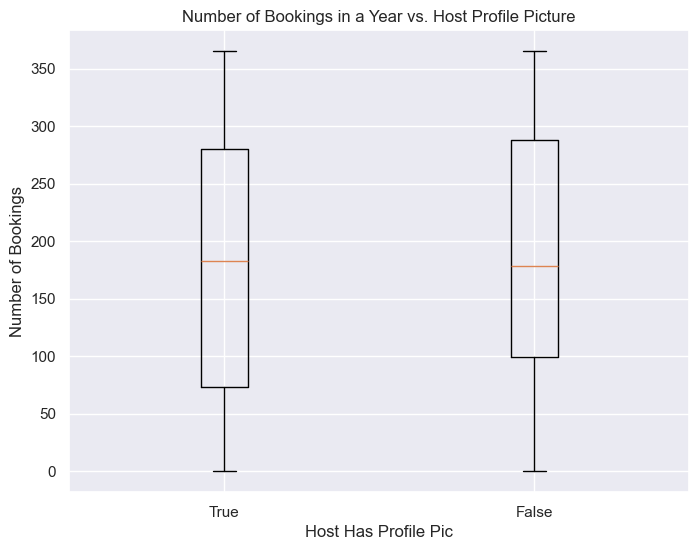

In [7]:
# 4. Does having a profile picture affect the popularity of a host's listing?
def pfp_bookings(listings):
    """
    Determines whether the host has a profile picture and the listing’s
    number of bookings in the next year to evaluate whether there is a correlation

    >>> pfp_bookings(listings_test)
    '-88.33333333333334'
    """
    listings["num_bookings"] = 365 - listings["availability_365"]

    true_data = listings[listings["host_has_profile_pic"] == "t"]["num_bookings"]
    false_data = listings[listings["host_has_profile_pic"] == "f"]["num_bookings"]

    plt.figure(figsize=(8, 6))
    plt.boxplot([true_data, false_data], labels=["True", "False"])
    plt.xlabel("Host Has Profile Pic")
    plt.ylabel("Number of Bookings")
    plt.title("Number of Bookings in a Year vs. Host Profile Picture")
    plt.grid(True)

    print("Mean bookings with Profile Picture:", round(true_data.mean(), 2))
    print("Mean bookings without Profile Picture:", round(false_data.mean(), 2))
    print("Median bookings with Profile Picture:", round(true_data.median(), 2))
    print("Median bookings without Profile Picture:", round(false_data.median(), 2))

    # Again, I know returned value is not used, but using it for doctest
    return (true_data.mean() - false_data.mean())

    plt.show()

pfp_bookings(listings)

# Implications and Limitations
My analysis can be used by urban planners and policymakers to view the density and prices of Airbnbs in
different neighborhoods, and this data can be used in monitoring properties and when implementing
regulations in the future. Furthermore, it can be used by hosts to analyze whether their properties are likely
to be successful based on factors such as price, the number of people it accomodates, their response rate,
and their ratings; it also shows how much of an effect on popularity these factors have (significance). Lastly,
the interactive map imitates that of the Airbnb app or website; it is a convenient way for customers to view
all listings in Seattle and their characteristics.
However, listings with empty values may be dropped in some of these functions, exluding those listings
from being analyzed. Moreover, these values were last scraped in March, and do not currently reflect
updated listings. I also would have liked to be able to view when these Airbnbs were originally listed in order
to analyze whether they are becoming more expensive or dense.
While many of these functions, such as the host profile pictures, may suggest a correlation, it does not
necessarily guarantee causation. The machine learning models are not perfectly accurate and cannot
guarantee the popularity of a listing